In [68]:
import pandas as pd
import numpy as np

import astropy.units as u
from astropy.constants import R_sun, L_sun, muB, mu0

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("/home/ekaterina/Documents/001_science/MalachiteMountains/analysis/results/mcmc/mcmcoutput.csv",)
df = df.drop_duplicates(keep=False)
df.columns

Index(['ED_s_16', 'ED_s_50', 'ED_s_84', 'Eflare_erg_16', 'Eflare_erg_50',
       'Eflare_erg_84', 'ID', 'a_16', 'a_50', 'a_84', 'color', 'frac_area_16',
       'frac_area_50', 'frac_area_84', 'fwhm_d_16', 'fwhm_d_50', 'fwhm_d_84',
       'i_deg_16', 'i_deg_50', 'i_deg_84', 'latitude_deg_16',
       'latitude_deg_50', 'latitude_deg_84', 'linestyle', 'phase_deg_16',
       'phase_deg_50', 'phase_deg_84', 'rad_rsun_16', 'rad_rsun_50',
       'rad_rsun_84', 'suffix', 't0_d_16', 't0_d_50', 't0_d_84', 'tstamp'],
      dtype='object')

In [74]:
def minimum_field(eflare, aspot, fraction=1.):
    """Shibata 2013"""
    f1 = eflare / (7e32 * u.erg)
    f2 = 0.1 / fraction
    f3 = np.sqrt((3e19 * u.cm**2 / aspot)**2)
    return np.sqrt(f1 * f2 * f3) * 1e3 * u.Gauss

In [4]:
df["minB"] = df.apply(lambda x: minimum_field(float(x.Eflare_erg_50)*u.erg, 
                                 float(x.frac_area_50)*4*np.pi*float(x.rad_rsun_50)**2 * R_sun**2).to("Gauss"), axis=1)

In [5]:
df[["ID","minB","ED_s_50"]]

,ID,minB,ED_s_50
0,277539431,16.864630968528836 G,28430.4519399802
2,237880881,7.652042704640673 G,4987.53301895416
4,237880881,42.87514812953519 G,4724.91710976565
6,44984200,41.7195719145615 G,2378.0611041521
8,44984200,35.433967648459095 G,1888.13959536431
10,44984200,80.9413942787978 G,458.195880956968
12,100004076,212.0730082649769 G,2957.1825994608


In [60]:
def bspotfield(amplitude, Lstar, efoldingflare, Aphot, dFrot, Tspot, Tphot, i):
    """From Notsu et al. 2013.
    
    Parameters:
    -----------
    
    
    Return:
    -------
    B : magneti field strength in the spot
    """
    f1 = 1. / (8 * np.pi * Lstar * efoldingflare * amplitude)
    print((1/f1).to("erg"))
    f2 = np.sqrt(((Aphot * dFrot) / ((1 - (Tspot/Tphot)**4) * np.sin(i)))**3)
    print(f2.decompose())
    return 1/(f1 * f2)

In [61]:
rotvals = pd.read_csv("/home/ekaterina/Documents/001_science/MalachiteMountains/analysis/results/rotation/rotvals.csv")

In [62]:
rotvals.ID

0     237880881.0
1     237880881.0
2      44984200.0
3      44984200.0
4      44984200.0
5     277539431.0
6     300741820.0
7     300741820.0
8     300741820.0
9     300741820.0
10    300741820.0
11    300741820.0
12    300741820.0
13    300741820.0
14    300741820.0
15    300741820.0
16    300741820.0
17    300741820.0
Name: ID, dtype: float64

In [63]:
dFrot = rotvals[rotvals.ID == float(flare.ID)].rel_amplitude.mean()
dFrot

0.005432627355323591

In [72]:
flare = df.iloc[0]

efoldingflare = flare.fwhm_d_50 * u.d
amplitude = flare.a_50
Aphot = 0.1 * 2. * np.pi *R_sun**2
Tspot = 2000 * u.K
Tphot = 2500 * u.K
Lstar = (np.power(10,-3.36) * L_sun).to("erg /s ")
i = 10 / 180 * np.pi
print(Lstar)
enden = bspotfield(amplitude, Lstar, efoldingflare, Aphot, dFrot, Tspot, Tphot, i).to("erg/m**3")

1.6709826058153558e+30 erg / s
1.3150840092960241e+36 erg
2.0456240387530885e+24 m3


In [73]:
np.sqrt(enden * mu0).decompose().to("Gauss")

<Quantity 2842.2925148 G>

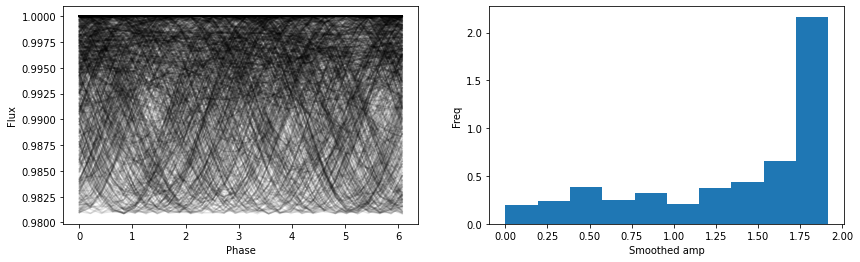

In [12]:

from fleck import Star, generate_spots

spot_contrast = 0.1
u_ld = [0.5079, 0.2239]
relampl = .012565

n_phases = 30
n_inclinations = 1000
n_spots = 1

spot_radius = 0.13  # Rspot/Rstar
min_latitude = 10   # deg
max_latitude = 30   # deg

lons, lats, radii, inc_stellar = generate_spots(min_latitude, max_latitude,
                                                spot_radius, n_spots,
                                                n_inclinations=n_inclinations)

stars = Star(spot_contrast=spot_contrast, n_phases=n_phases, u_ld=u_ld)
lcs = stars.light_curve(lons, lats, radii, inc_stellar)

smoothed_amps = 100 * lcs.ptp(axis=0) #preserve type

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(stars.phases, lcs, alpha=0.1, color='k')
ax[0].set(xlabel='Phase', ylabel='Flux')

ax[1].hist(smoothed_amps, density=True)
ax[1].set(xlabel='Smoothed amp', ylabel='Freq')

plt.show()